## **Bibliothéque :** 

In [ ]:
#Bibliotheques

import tensorflow as tf
#tf.config.run_functions_eagerly(True)
import numpy as np 
from keras.models import Sequential,Input,Model
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import confusion_matrix
from matplotlib import image 
from matplotlib import pyplot as plt 

## **Filtre Bank Architecture**

In [ ]:
Nm =7
Nt = 1024
Nf=7

def model_F_Bank( shp = (1, Nt, Nm) ):
  
  inputs =tf.keras.Input(shape=shp)
  x1 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,1))(inputs)
  norm1 = tf.keras.layers.LayerNormalization()(x1)
  act1 = tf.keras.layers.Activation('tanh')(norm1)

  x2 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,2))(act1)
  add1 = tf.keras.layers.Add()([x1,x2])
  norm2 = tf.keras.layers.LayerNormalization()(add1)
  act2 = tf.keras.layers.Activation('tanh')(norm2)

  x4 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,4))(act2)

  add2 = tf.keras.layers.Add()([x2, x4])
  norm3 = tf.keras.layers.LayerNormalization()(add2)
  act3 = tf.keras.layers.Activation('tanh')(norm3)

  x8 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,8))(act3)

  add3 = tf.keras.layers.Add()([x4, x8])
  norm4 = tf.keras.layers.LayerNormalization()(add3)
  act4 = tf.keras.layers.Activation('tanh')(norm4)


  x16 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,16))(act4)

  add4 = tf.keras.layers.Add()([x8, x16])
  norm5 = tf.keras.layers.LayerNormalization()(add4)
  act5 = tf.keras.layers.Activation('tanh')(norm5)

  x32 = tf.keras.layers.SeparableConv2D(filters=Nf, kernel_size=(1,3), padding='same', dilation_rate=(1,32))(act5)

  add5 = tf.keras.layers.Add()([x16, x32])
  norm6 = tf.keras.layers.LayerNormalization()(add5)
  output = tf.keras.layers.Activation('tanh')(norm6)

  model = tf.keras.Model(inputs=inputs, outputs=output)

  return model

## **Definition l'architecture (casdade de filtre + Bloc d'énergie) :**

In [ ]:
def BLearning_model():
  #Création d'un bank filtre 
  model1 = model_F_Bank()

  modelf = Sequential()
  modelf.add(model1)
  
  #Bloc calculant la pseudo énergie 
  modelf.add(tf.keras.layers.Lambda(lambda x: x ** 2))
  #Suppression des valeurs qui correspondent au padding 
  modelf.add(tf.keras.layers.Cropping2D(cropping=((0,0),(96,96))))
  #Couche qui calcule l'énergie moyenne 
  modelf.add(tf.keras.layers.AveragePooling2D((1,832)))
  modelf.add(tf.keras.layers.Activation('selu'))
  modelf.add(tf.keras.layers.Flatten())

  #Fully connected layers
  modelf.add(tf.keras.layers.Dense(128, activation='relu'))
  modelf.add(tf.keras.layers.Dense(64, activation='relu'))
  modelf.add(tf.keras.layers.Dense(32, activation='relu'))
  modelf.add(tf.keras.layers.Dense(4, activation='softmax'))

  #Compiler et afficher le model
  modelf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  modelf.summary()

  return modelf

# **Apprentissage du réseau :** 

In [ ]:
# fonction pour melanger notre base de données

def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [ ]:
#definition du model
model = BLearning_model()
#Replace your data path
data_path = 'Database_bruite.npy'
Label_path = 'Label_bruite.npy'
# X donnees d'entrainement y les labels
X = np.load(data_path)
Y = np.load(Label_path)

X,Y = shuffle_in_unison(X, Y)

# Base d'entrainement 
X_tr = X[0:10000]
Y_tr = Y[0:10000]

# base de test
X_ts = X[10000:10800]
Y_ts = Y[10000:10800]

#process_data
#train
X2_tr = []
for x in X_tr:
  X2_tr.append(np.expand_dims(x.T,0))
X2_tr = np.array(X2_tr)
#test
X2_ts = []
for x in X_ts:
  X2_ts.append(np.expand_dims(x.T,0))
X2_ts = np.array(X2_ts)


#train label
Y_tr_OH = to_categorical(Y_tr)
#test label
Y_ts_OH = to_categorical(Y_ts)

print(X2_tr.shape,' et ',Y_tr_OH.shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1, 1024, 7)        546       
                                                                 
 lambda_1 (Lambda)           (None, 1, 1024, 7)        0         
                                                                 
 cropping2d_1 (Cropping2D)   (None, 1, 832, 7)         0         
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 7)          0         
 ePooling2D)                                                     
                                                                 
 activation_13 (Activation)  (None, 1, 1, 7)           0         
                                                                 
 flatten_1 (Flatten)         (None, 7)                 0         
                                                      

(200.0, 800.0)

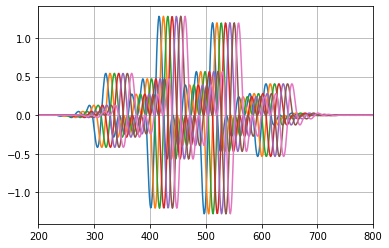

In [ ]:
#Exemple de signal dans notre base
import matplotlib.pyplot as plt
plt.grid()
plt.plot(X2_tr[0][0][:])
plt.xlim([200,800])

### **Entrainement du Model :**

In [ ]:
Epochs = 20
Batch_size = 128
history = model.fit(x=X2_tr, y=Y_tr_OH, batch_size=Batch_size, epochs= Epochs, verbose='auto',validation_split=0.2, shuffle=True)

Epoch 1/20
63/63 [==============================] - 28s 261ms/step - loss: 1.2979 - accuracy: 0.4034 - val_loss: 1.0686 - val_accuracy: 0.5095
Epoch 2/20
63/63 [==============================] - 15s 245ms/step - loss: 0.7813 - accuracy: 0.6407 - val_loss: 0.5963 - val_accuracy: 0.7225
Epoch 3/20
63/63 [==============================] - 16s 262ms/step - loss: 0.4268 - accuracy: 0.8773 - val_loss: 0.2674 - val_accuracy: 0.9385
Epoch 4/20
63/63 [==============================] - 15s 245ms/step - loss: 0.2194 - accuracy: 0.9469 - val_loss: 0.1574 - val_accuracy: 0.9630
Epoch 5/20
63/63 [==============================] - 15s 245ms/step - loss: 0.1318 - accuracy: 0.9685 - val_loss: 0.1207 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 15s 245ms/step - loss: 0.1017 - accuracy: 0.9720 - val_loss: 0.1114 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 15s 246ms/step - loss: 0.0841 - accuracy: 0.9764 - val_loss: 0.0779 - val_accuracy: 0.9795

## **Test du modèle :**

In [ ]:
# matrice de confusion 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[202   3   0   0]
 [  1 197   0   0]
 [  2   0 193   3]
 [  0   0   0 199]]


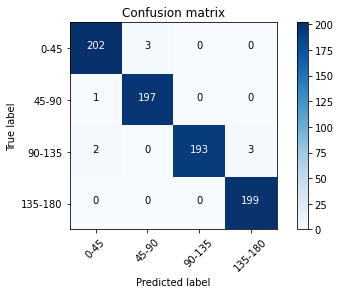

In [ ]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools
predictions = model.predict(X2_ts, batch_size=None, verbose=0)
cm = confusion_matrix(y_true=Y_ts,y_pred=predictions.argmax(axis=1))
Labels = ['0-45','45-90','90-135','135-180']
plot_confusion_matrix(cm=cm, classes=Labels)

### **Afficher 7 signaux de microphones et leur classe réel :** 

--------------------------------------
--------------------------------------
     la classe  de notre signal  1
--------------------------------------
--------------------------------------

 



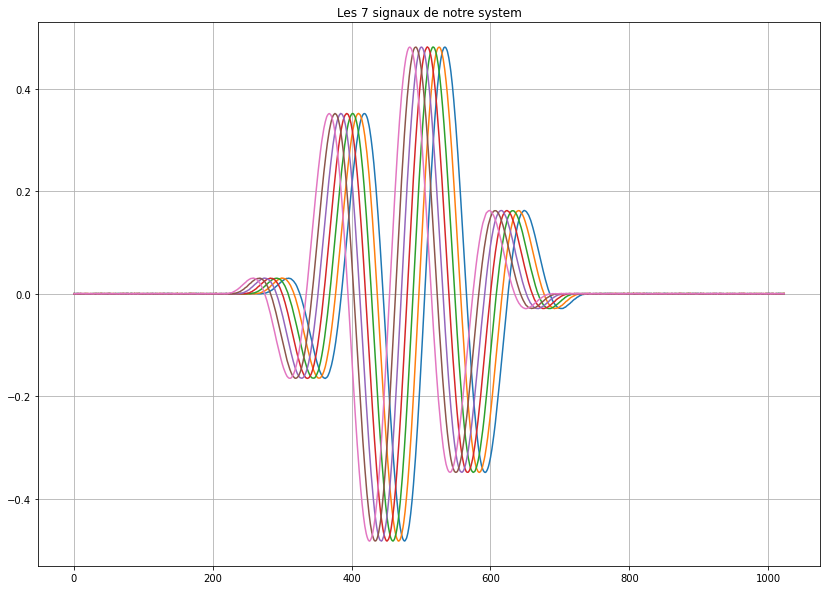

In [ ]:
n = 3
Exemple = X2_ts[n]

plt.figure(figsize=(14,10))
plt.grid()
plt.plot(Exemple[0])
plt.title('Les 7 signaux de notre system') 
print('--------------------------------------')
print('--------------------------------------')
print('     la classe  de notre signal ',Y_ts[n]+1)
print('--------------------------------------')
print('--------------------------------------')
print('\n \n')

### **Prédire a l'aide de notre modèle la classe d'apartenance du signal source :** 

---------------------------------------------
---------------------------------------------
Notre source se situe entre :  0-45 degrees
---------------------------------------------
---------------------------------------------

 



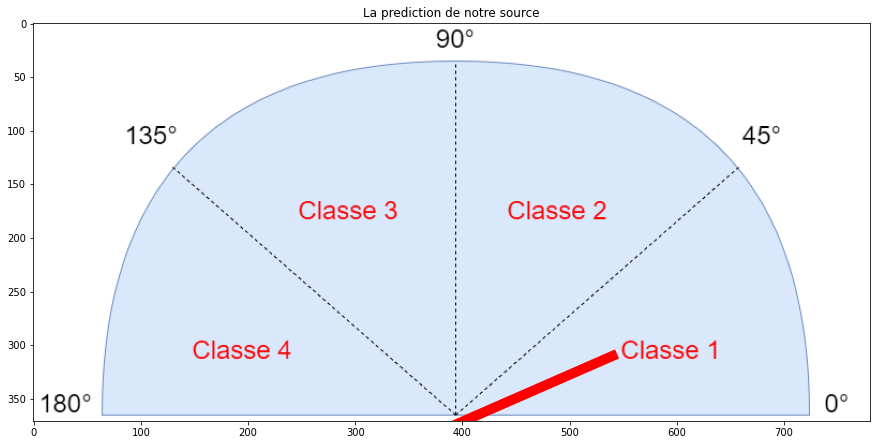

In [ ]:
pred = model.predict(np.expand_dims(Exemple,0))
data = image.imread('/Test/DataBeam/resul.png') 

print('---------------------------------------------')
print('---------------------------------------------')
print('Notre source se situe entre : ', Labels[pred.argmax()],'degrees')
print('---------------------------------------------')
print('---------------------------------------------')
print('\n \n')

if pred.argmax() == 0:
    x1 = [380, 540] 
    y1 = [380, 310]
elif pred.argmax() == 1:
    x1 = [380, 500] 
    y1 = [390, 200]
elif pred.argmax() == 2:
    x1 = [400, 300] 
    y1 = [380, 200]
else:
    x1 = [400, 250] 
    y1 = [380, 310]

plt.figure(figsize=(15,15))
plt.plot(x1, y1, color="red", linewidth=10) 
plt.axis('on')
plt.title('La prediction de notre source') 
plt.imshow(data)
plt.show()